In [97]:
######################################################################################################
########################################## Import Libraries ##########################################
######################################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from imblearn.under_sampling import (
    RandomUnderSampler,
    NearMiss,
    TomekLinks
)
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN
)
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [52]:
######################################################################################################
###########################################  Load Datasets ###########################################
######################################################################################################

train_path = "train.csv"
test_path = "test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## **2. Data Preprocessing and Exploratory Data Analysis**


In [53]:
######################################################################################################
########################## Data Preprocessing and Exploratory Data Analysis ##########################
######################################################################################################

# ================================  Task 1: Understanding the Dataset ================================

print(f"Training Dataset Shape: {train.shape}") # Print the shape of the training dataset
print(f"Test Dataset Shape: {test.shape}") # Print the shape of the test dataset
print()
print(f"Datasets Looks Like: \n{train.head()}\n") # Print the first few rows of the training dataset
print()
print(f"Datasets Information (Overview): \n{train.info()}")  # Display a concise summary of the DataFrame
print()
print(f"Datasets Descriptive Statistics: \n{train.describe()}")  # Generate descriptive statistics
print()
print(f"Datasets Columns: \n{train.columns.to_list()}")  # Get column names as a list
print()
print(f"Datasets Missing Values: \n{train.isnull().sum()}")  # Count missing values in each column
print()
print(f"Datasets Unique Values: \n{train.nunique()}")  # Count unique values in each column
print()

Training Dataset Shape: (6256, 15)
Test Dataset Shape: (1564, 15)

Datasets Looks Like: 
   index                                            Address      Possesion  \
0   6250  Arihant housing society, Sai Nagar, Kandivali ...  Ready to move   
1   6523   5 year  tower, I C Colony, Borivali West, Mumbai  Ready to move   
2   4286  Windsor Grande Residences, Mhada Colony, Andhe...  Ready to move   
3   5038           Maharashtra Nagar, Borivali West, Mumbai  Ready to move   
4   8491                                Bandra West, Mumbai  Ready to move   

       Furnishing  Buildup_area  Carpet_area  Bathrooms  Property_age  \
0  Semi Furnished         615.0   508.043150        1.0            12   
1  Semi Furnished        1200.0   724.772558        3.0             5   
2  Semi Furnished        3300.0  2300.000000        5.0             6   
3     Unfurnished         800.0   642.570682        1.0            25   
4  Semi Furnished        2000.0  1602.321210        4.0            10   

   

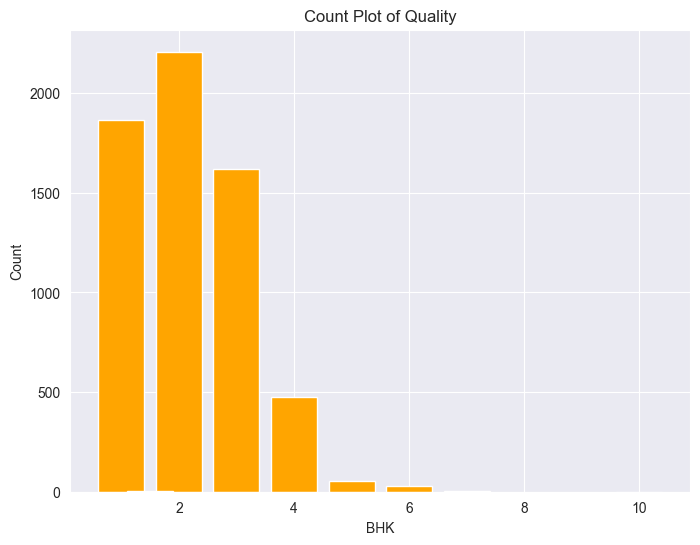

In [54]:
Prices = train['BHK'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(Prices.index, Prices, color='orange')
plt.title('Count Plot of Quality')
plt.xlabel('BHK')
plt.ylabel('Count')
plt.show()

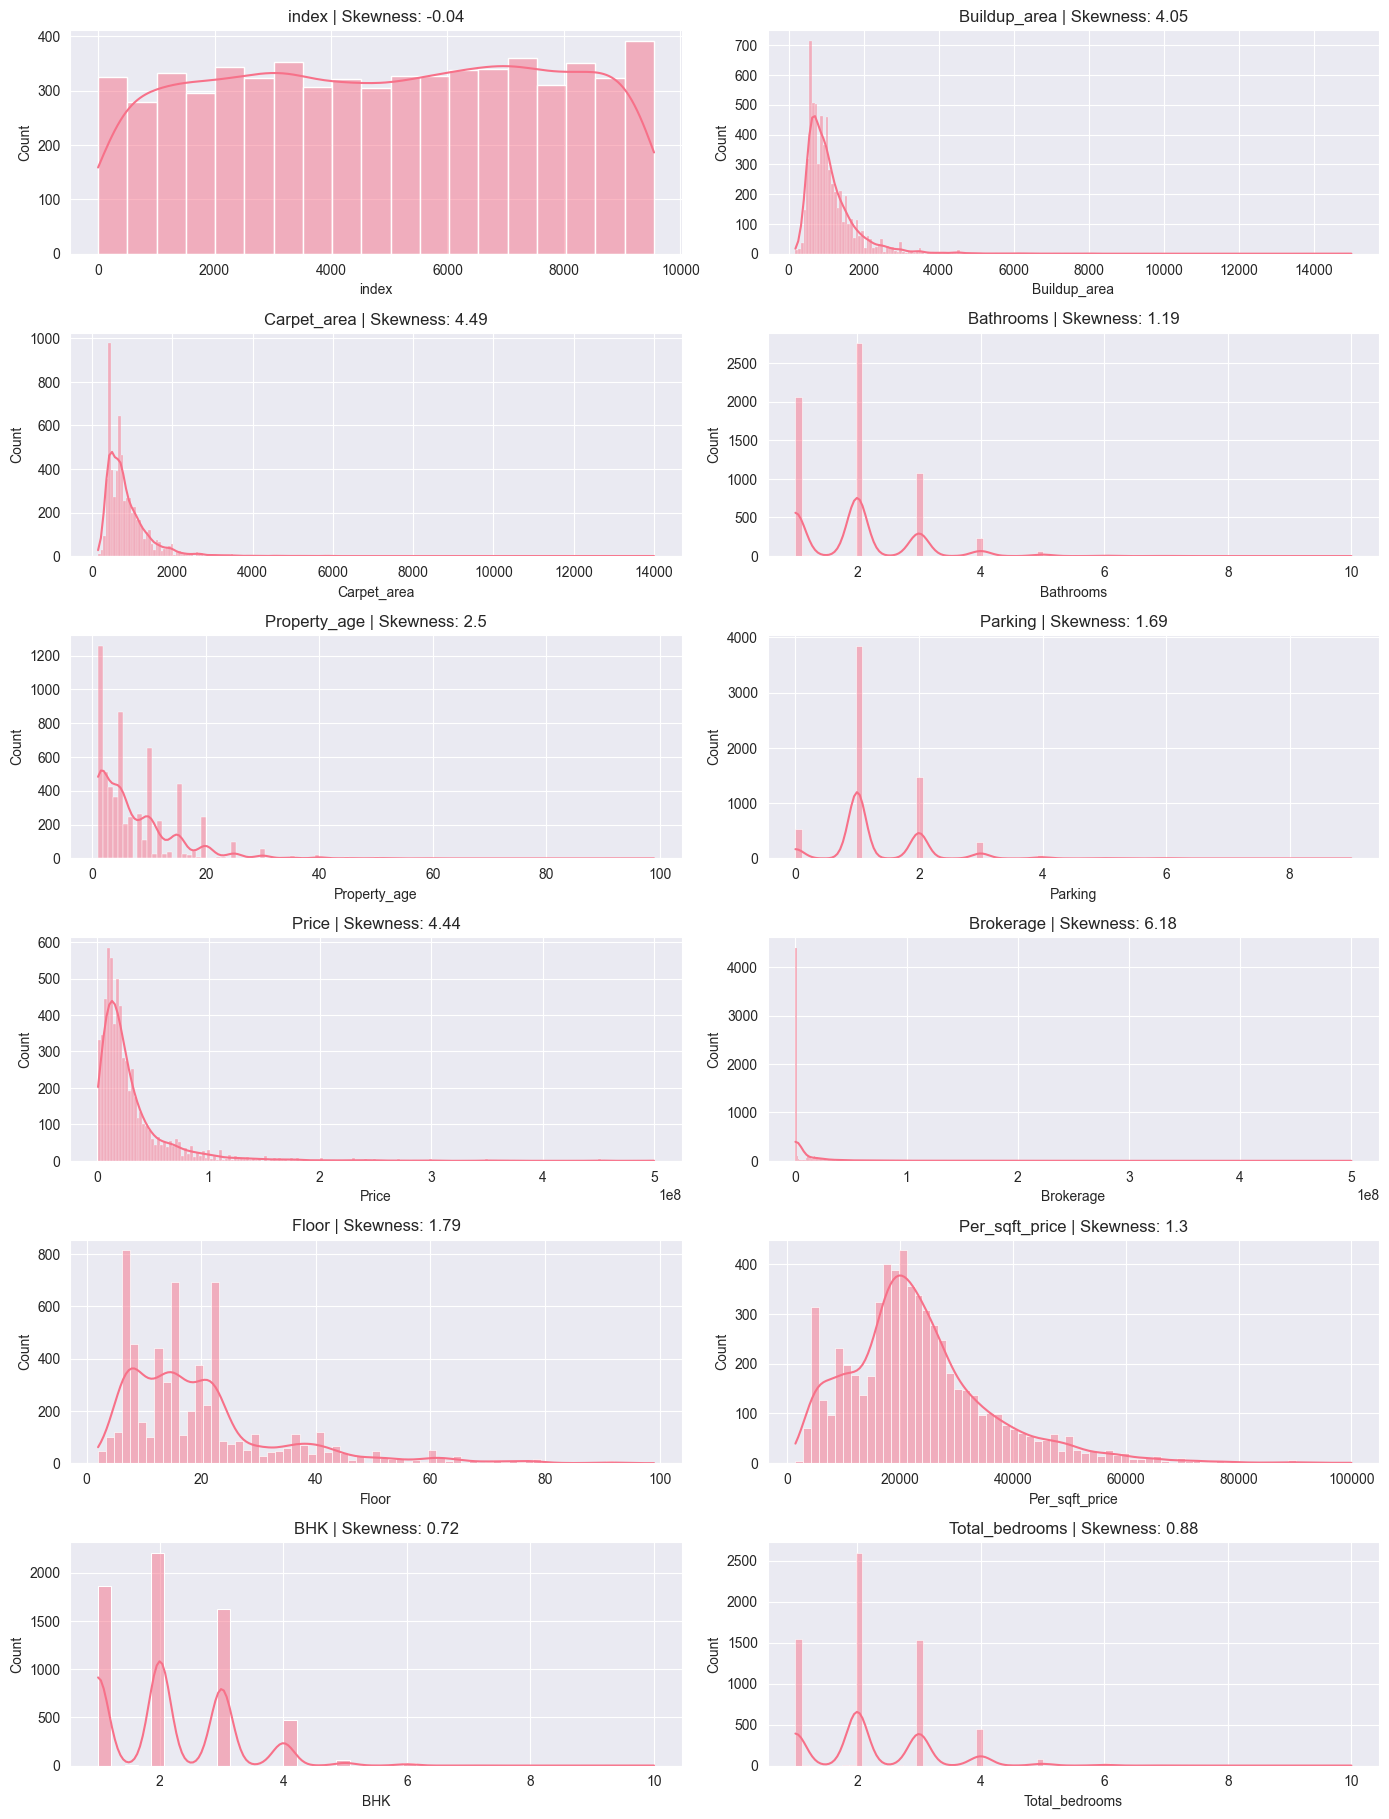

In [55]:
sns.set_style("darkgrid")

plt.figure(figsize=(14, len(train.select_dtypes(include=["int64", "float64"]).columns) * 3))
for idx, feature in enumerate(train.select_dtypes(include=["int64", "float64"]).columns, 1):
    plt.subplot(len(train.select_dtypes(include=["int64", "float64"]).columns), 2, idx)
    sns.histplot(train[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(train[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

C:\Users\techn\AppData\Local\Temp\ipykernel_2872\425283857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x="Total_bedrooms", y="Furnishing", data=train, palette='viridis')
f:\MTech_IIITD\Semester 1\Artificial Intelligence\Assignment_4\assEnv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 93.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
f:\MTech_IIITD\Semester 1\Artificial Intelligence\Assignment_4\assEnv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 93.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
f:\MTech_IIITD\Semester 1\Artificial Intelligence\Assignment_4\assEnv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8

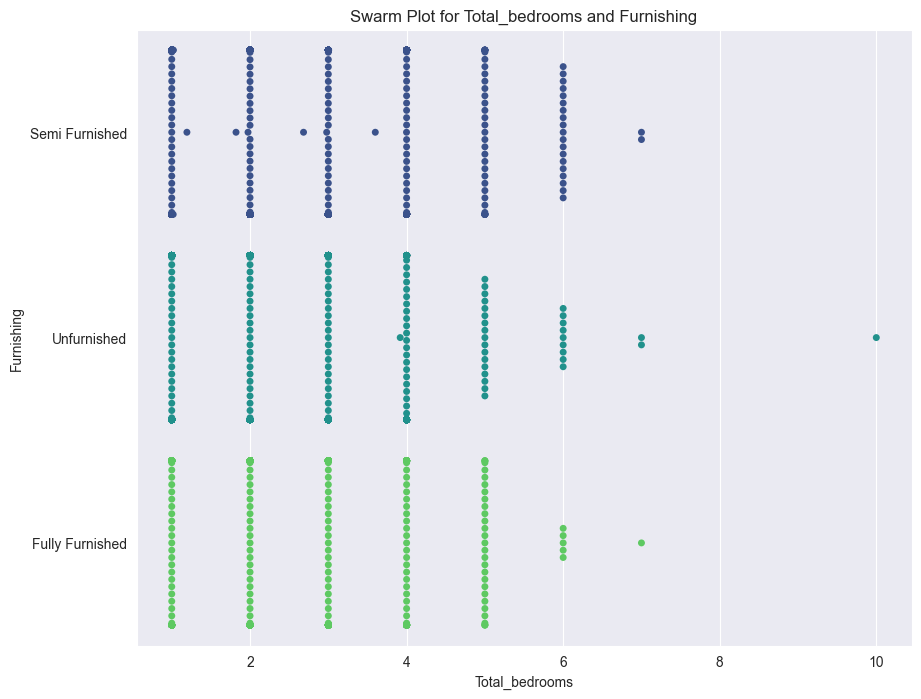

In [56]:
plt.figure(figsize=(10, 8))
sns.swarmplot(x="Total_bedrooms", y="Furnishing", data=train, palette='viridis')

plt.title('Swarm Plot for Total_bedrooms and Furnishing')
plt.xlabel('Total_bedrooms')
plt.ylabel('Furnishing')
plt.show()

<Figure size 1000x600 with 0 Axes>

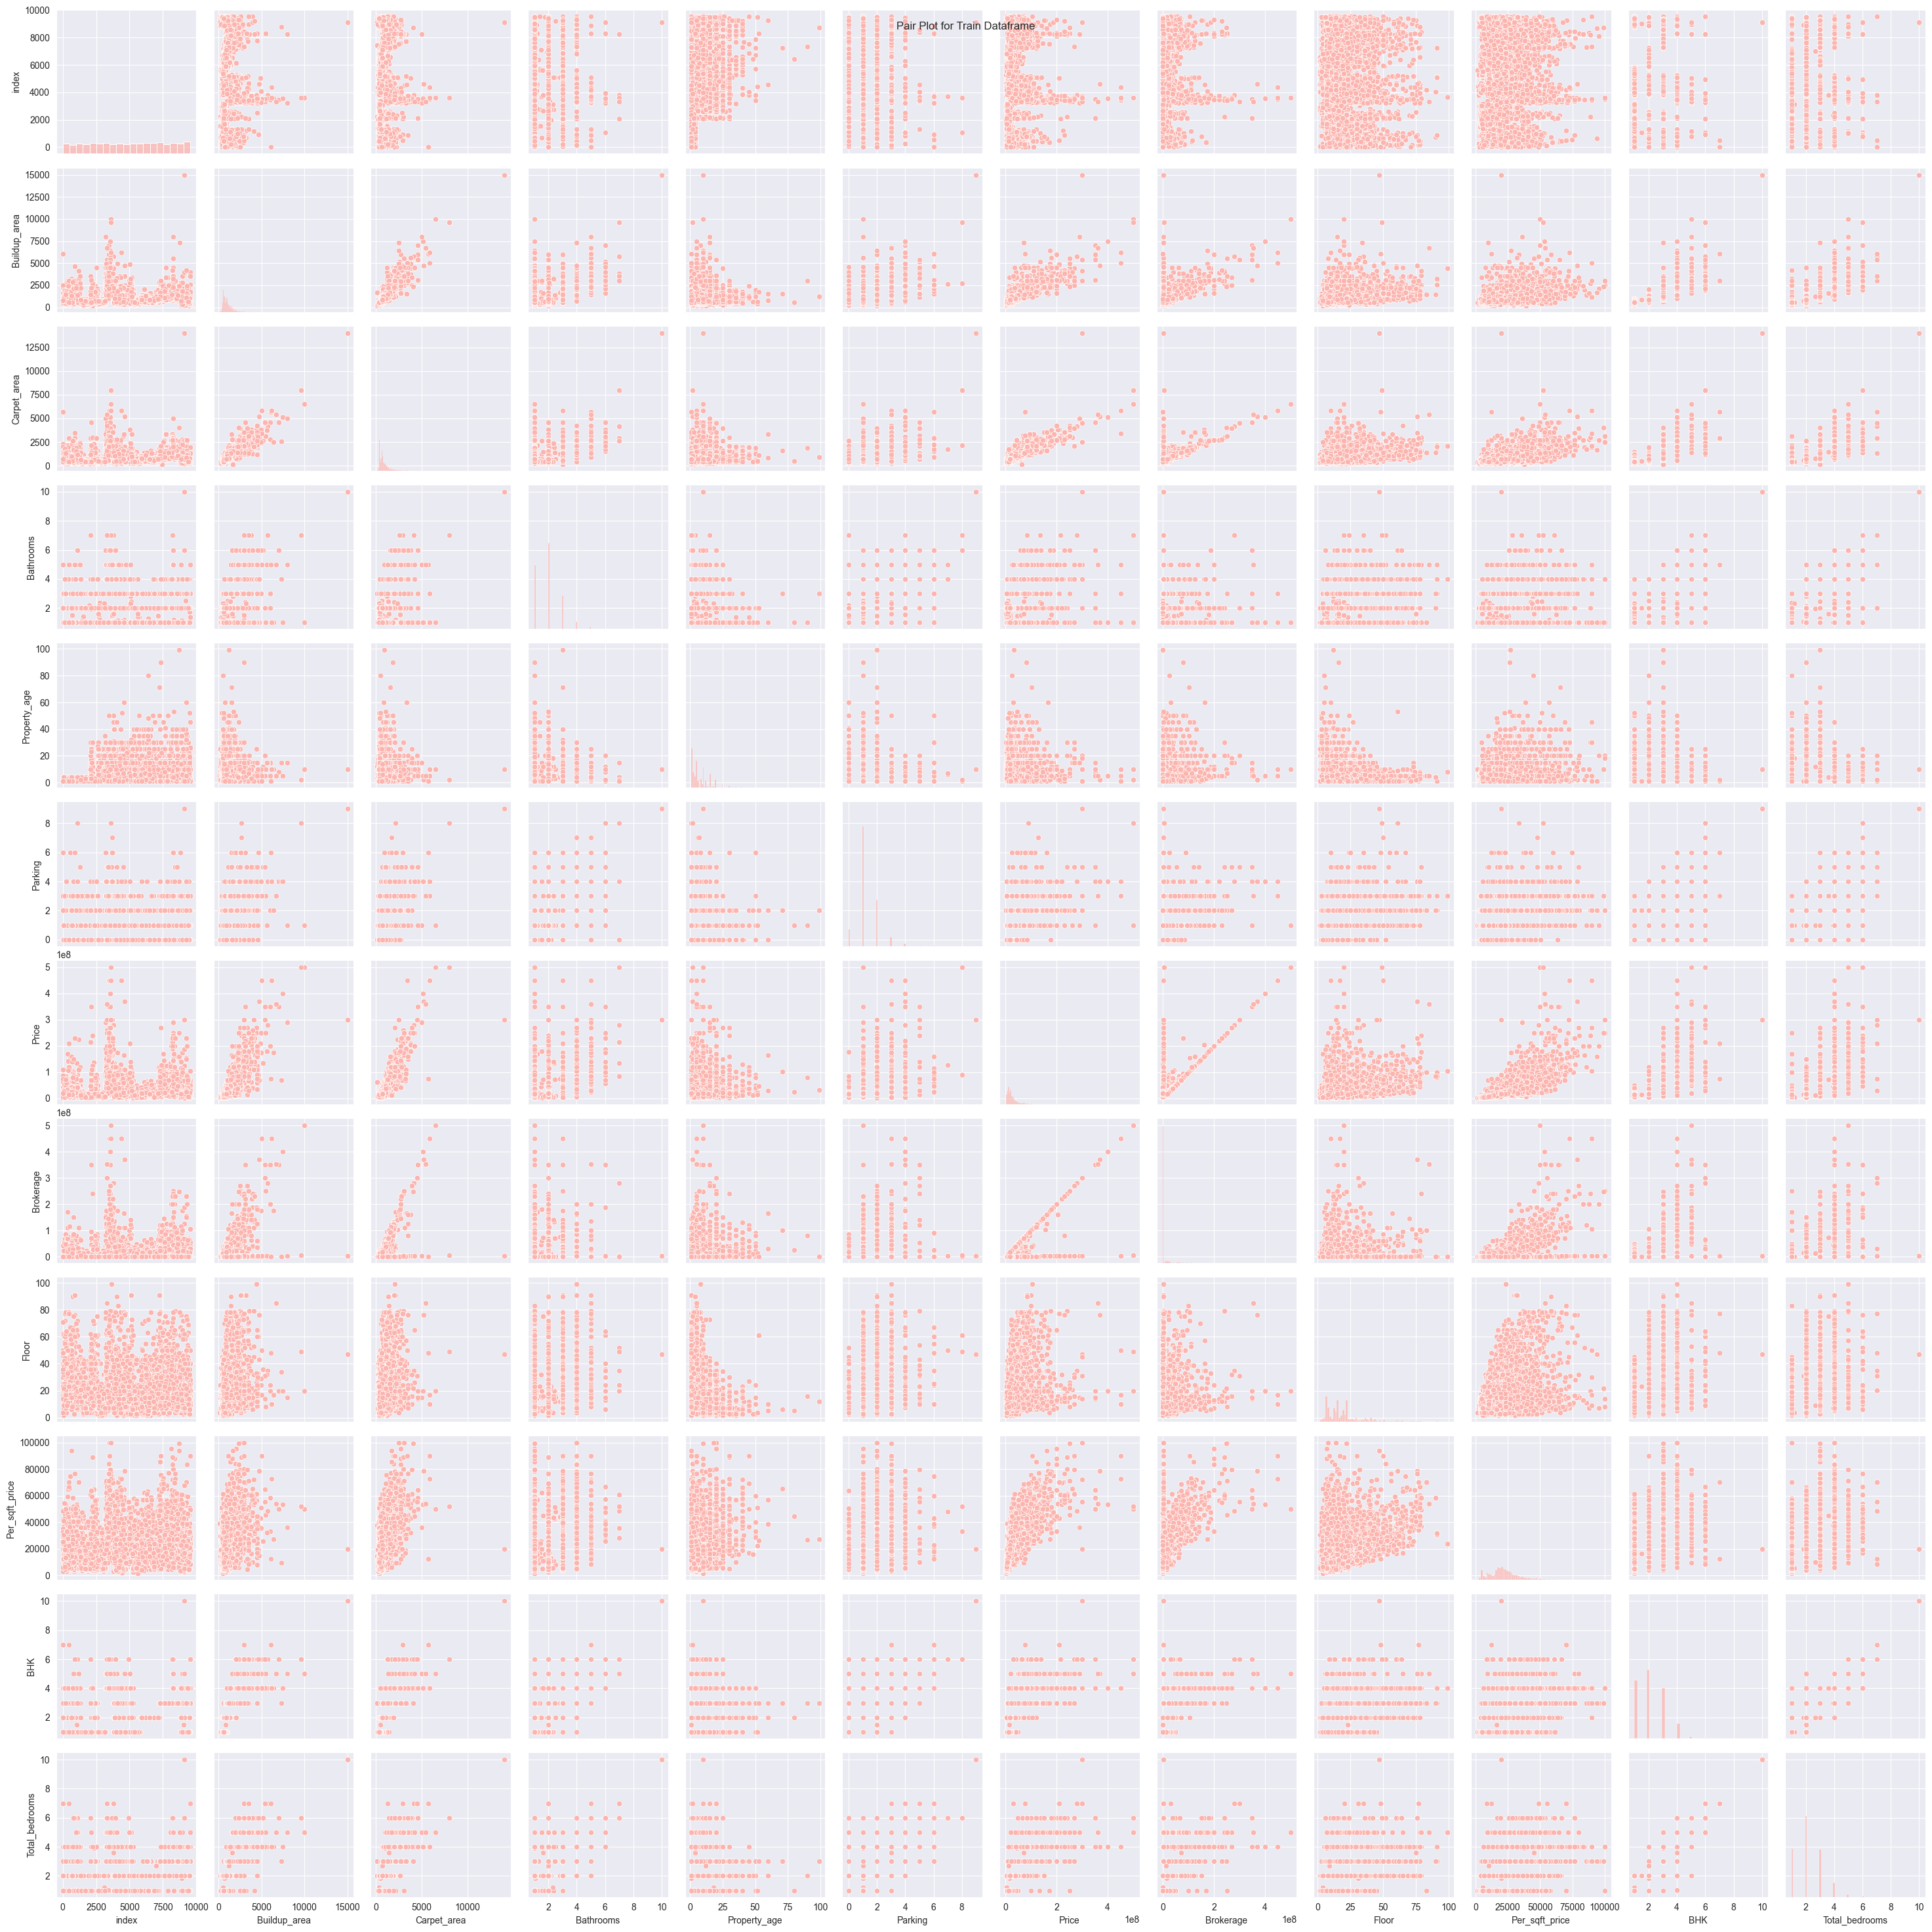

In [57]:
sns.set_palette("Pastel1")
plt.figure(figsize=(10, 6))
sns.pairplot(train)

plt.suptitle('Pair Plot for Train Dataframe')
plt.show()

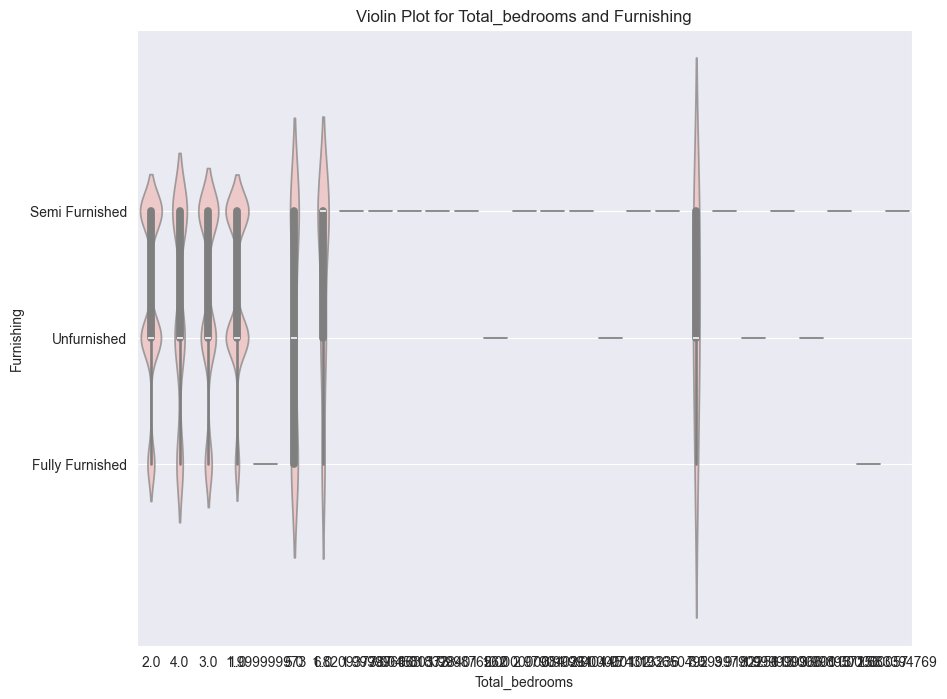

In [58]:
train['Total_bedrooms'] = train['Total_bedrooms'].astype(str)  # Convert 'Total_bedrooms' to categorical
plt.figure(figsize=(10, 8))

# Using Seaborn to create a violin plot
sns.violinplot(x="Total_bedrooms", y="Furnishing", data=train, alpha=0.7)

plt.title('Violin Plot for Total_bedrooms and Furnishing')
plt.xlabel('Total_bedrooms')
plt.ylabel('Furnishing')
plt.show()

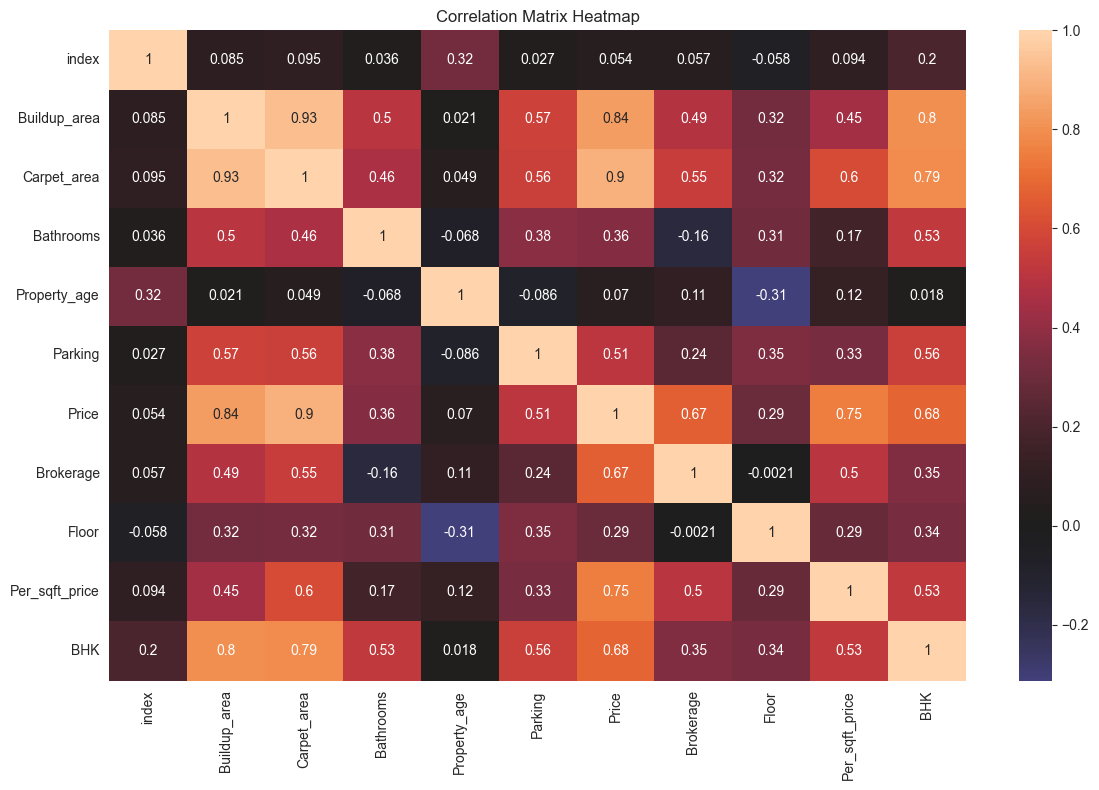


Columns with low correlation to Price (between -0.1 and 0.1):

index:
Correlation coefficient with Price: 0.0536
Reason for dropping: Weak linear relationship with target variable

Property_age:
Correlation coefficient with Price: 0.0696
Reason for dropping: Weak linear relationship with target variable


In [59]:
# =================================  Task 2: Drop Irrelevant Columns =================================
# Remove the columns identified through correlation analysis with a correlation coefficient within the range of -0.1 to 0.1, 
# as well as those that lack predictive power and do not contribute meaningfully to the target variable. 
# Provide reasons for dropping each of these columns.


corr_mat = train[train.select_dtypes(include=['int64', 'float64']).columns].corr()
plt.figure(figsize=(12, 8))
sns.set_palette("husl")
sns.heatmap(corr_mat, annot=True, center=0)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

p_corr = corr_mat['Price'].abs()
remove_corr_cols = p_corr[(p_corr > -0.1) & (p_corr < 0.1)].index.tolist()

print("\nColumns with low correlation to Price (between -0.1 and 0.1):")
for col in remove_corr_cols:
    print(f"\n{col}:")
    print(f"Correlation coefficient with Price: {corr_mat['Price'][col]:.4f}")
    print("Reason for dropping: Weak linear relationship with target variable")

train = train.drop(remove_corr_cols, axis=1) # Drop columns with low correlation
test = test.drop(remove_corr_cols, axis=1) # Drop columns with low correlation

# Remove those columns with less predictive and use less
# 1. index - It just show the row number
# 2. Possesion - Its just a dummy variable: same for all the data
# 3. Per_sqft_price - Its derived data from price and area
# 4. Address - May or may not be affected

train = train.drop(['Possesion', 'Per_sqft_price', 'Address'], axis=1)
test = test.drop(['Possesion', 'Per_sqft_price', 'Address'], axis=1)

> ### **_High Cardinality Impact_**

> - Issues:

- - High cardinality makes the data sparse, which can make it harder for models to find patterns and generalize well.
    Label encoding can create a false sense of order among categories, which might mislead the model.

> - Mitigation:

- - 1. Clustering: Combine similar addresses into groups, like neighborhoods or regions.
- - 2. Frequency Encoding: Use how often an address appears as its encoded value.
- - 3. Domain Knowledge: Break addresses into meaningful parts, such as city or locality.
- - 4. Embeddings: For advanced cases, use techniques from deep learning to reduce the complexity of categorical data.

> ### **_Key Improvements and Features of This Implementation_**

> 1. Better Handling of High Cardinality:
>
> - The implementation deals with the high number of unique values in the Address column by:
> - - Breaking down addresses into smaller, meaningful parts (e.g., locality).
> - - Grouping uncommon addresses into a single "rare" category.
> - - Applying label encoding after reducing the number of unique values.
>
> 2. Error Handling:
>
> - The code checks for common issues like:
> - - Missing files or columns.
> - - Incorrect data formats.
> - - Other processing errors.
>
> 3. Storing Encoded Information:
>
> - The implementation keeps mappings of original values to encoded ones, which helps in:
> - - Understanding the model’s results.
> - - Applying the same encoding to new data during prediction.
> - - Converting predictions back to their original form.
>
> 4. Handling Rare Categories:
>
> - You can control how rare categories are handled using a rare_threshold parameter. This flexibility lets you decide how many unique values to keep and how many to group together.
>
> 5. Clean and Organized Code:
>
> - The code is split into simple, well-documented functions:
> - - encode_categorical_features: Handles the actual encoding process.
> - - process_categorical_features: Manages higher-level tasks, including error handling and preprocessing.


In [61]:
# ==============================  Task 3: Encoding Categorical Features ==============================

# # Convert categorical features to numerical using one-hot encoding
# train = pd.get_dummies(train, drop_first=True)
# test = pd.get_dummies(test, drop_first=True)
# train.head()

# Convert categorical features to numerical using label encoding
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
encoder = LabelEncoder()
for col in categorical_columns:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])
train.head()

Furnishing  Buildup_area  Carpet_area  Bathrooms  Parking      Price  \
0           1         615.0   508.043150        1.0        0   14500000   
1           1        1200.0   724.772558        3.0        1   18500000   
2           1        3300.0  2300.000000        5.0        3  125000000   
3           2         800.0   642.570682        1.0        1   16000000   
4           1        2000.0  1602.321210        4.0        2   85000000   

    Brokerage  Floor  BHK  Total_bedrooms  
0  14500000.0    7.0  2.0              12  
1  18500000.0   13.0  2.0              12  
2   1250000.0   32.0  4.0              23  
3  16000000.0    4.0  2.0              12  
4  85000000.0   12.0  3.0              17

In [62]:
# =====================================  Task 4: Feature Scaling =====================================
# In this task, we will use the StandardScaler from scikit-learn to scale the features of the dataset.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Create a StandardScaler object
train_scaled = scaler.fit_transform(train) # Fit the scaler to the data and transform it
test_scaled = scaler.transform(test) # Fit the scaler to the data and transform it

C:\Users\techn\AppData\Local\Temp\ipykernel_2872\3328096615.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_cnts.index, y=cat_cnts.values, palette='viridis')  # Bar plot of price categories


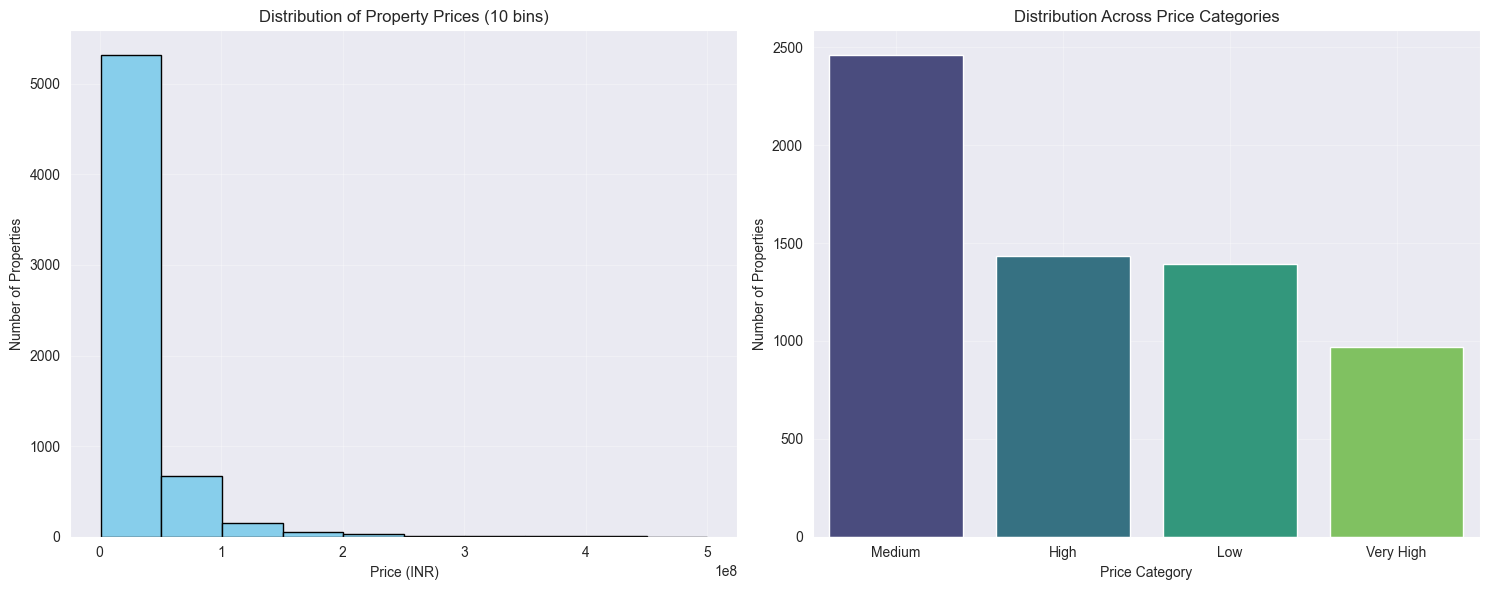


Detailed Distribution Analysis:

Price Category Distribution:
Medium: 2463 properties (39.37%)
High: 1434 properties (22.92%)
Low: 1391 properties (22.23%)
Very High: 968 properties (15.47%)

Statistical Analysis by Category:
            count          mean           std       min        max
P_Category                                                        
High         1434  3.428905e+07  6.867479e+06  25000000   49900000
Low          1391  6.021850e+06  2.444632e+06    780000    9950000
Medium       2463  1.654145e+07  4.191857e+06  10000000   24900000
Very High     968  9.608543e+07  5.902793e+07  50000000  500000000


In [63]:
# =========================== Task 5: Target Variable Imbalance Detection ============================
# Create a figure for price distribution analysis
plt.figure(figsize=(15, 6))

# Plot the distribution of property prices using 10 bins
plt.subplot(1, 2, 1)
plt.hist(train['Price'], bins=10, edgecolor='black', color='skyblue')  # Histogram of prices
plt.title('Distribution of Property Prices (10 bins)')
plt.xlabel('Price (INR)')
plt.ylabel('Number of Properties')
plt.grid(True, alpha=0.3)

# Function to categorize property prices
def cat_price(p):
    if p < 10000000:  # Below 1 crore
        return 'Low'
    elif p < 25000000:  # 1-2.5 crores
        return 'Medium'
    elif p < 50000000:  # 2.5-5 crores
        return 'High'
    else:  # Above 5 crores
        return 'Very High'

# Apply categorization to create a new column in the DataFrame
train['P_Category'] = train['Price'].apply(cat_price)  # Create a new column for price categories
test['P_Category'] = test['Price'].apply(cat_price)  # Create a new column for price categories

# Plot distribution of price categories using a bar plot
plt.subplot(1, 2, 2)
cat_cnts = train['P_Category'].value_counts()  # Count occurrences of each category
sns.barplot(x=cat_cnts.index, y=cat_cnts.values, palette='viridis')  # Bar plot of price categories
plt.title('Distribution Across Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Number of Properties')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the figure

# Print detailed statistics about the price category distribution
print("\nDetailed Distribution Analysis:")
print("\nPrice Category Distribution:")
for cat, cnt in cat_cnts.items():
    pct = (cnt / len(train)) * 100  # Calculate percentage
    print(f"{cat}: {cnt} properties ({pct:.2f}%)")  # Print category stats

# Calculate and print statistical measures for each price category
print("\nStatistical Analysis by Category:")
cat_stats = train.groupby('P_Category')['Price'].agg(['count', 'mean', 'std', 'min', 'max'])  # Aggregate stats
print(cat_stats)  # Print the statistical summary

Index(['Furnishing', 'Buildup_area', 'Carpet_area', 'Bathrooms', 'Parking',
       'Brokerage', 'Floor', 'BHK', 'Total_bedrooms'],
      dtype='object')


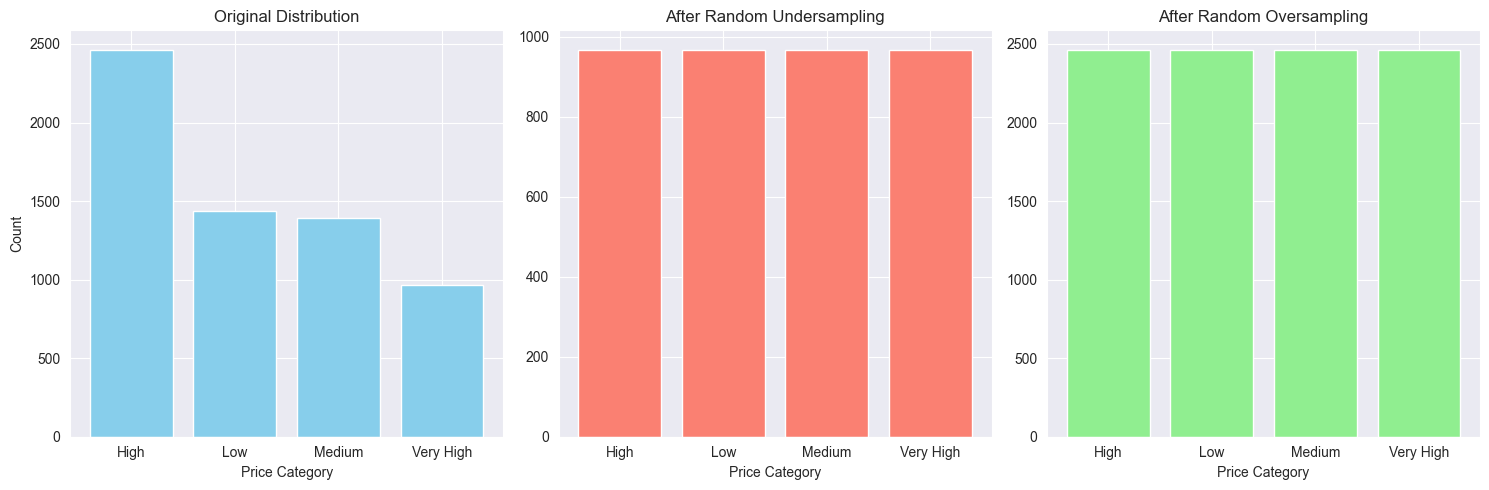


Detailed Resampling Analysis:

Original Distribution:
High: 1434 samples (22.92%)
Low: 1391 samples (22.23%)
Medium: 2463 samples (39.37%)
Very High: 968 samples (15.47%)

Distribution After Undersampling:
High: 968 samples (25.00%)
Low: 968 samples (25.00%)
Medium: 968 samples (25.00%)
Very High: 968 samples (25.00%)

Distribution After Oversampling:
High: 2463 samples (25.00%)
Low: 2463 samples (25.00%)
Medium: 2463 samples (25.00%)
Very High: 2463 samples (25.00%)

Dataset Size Comparison:
Original dataset: 6256 samples
After undersampling: 3872 samples
After oversampling: 9852 samples


In [80]:
# ================================= Task 6: Handling Imbalanced Data =================================
# X = train[['Buildup_area', 'Carpet_area', 'Bathrooms', 'Parking']]  # Feature variables
X = train.drop(['Price', 'P_Category'], axis=1)  # Feature variables
print(X.columns)
y = encoder.fit_transform(train['P_Category'])  # Encode target variable

# Create figure for visualizing the original and resampled distributions
plt.figure(figsize=(15, 5))

# Plot original distribution
plt.subplot(1, 3, 1)
orig_cnts = pd.Series(y).value_counts()  # Count occurrences in original data
plt.bar(range(len(orig_cnts)), orig_cnts.values, color='skyblue')  # Bar plot of original distribution
plt.title('Original Distribution')  # Title for original distribution
plt.xlabel('Price Category')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.xticks(range(len(orig_cnts)), encoder.classes_)  # Set x-ticks to correspond to price categories

# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)  # Initialize Random Undersampler
X_under, y_under = rus.fit_resample(X, y)  # Perform undersampling

# Plot undersampled distribution
plt.subplot(1, 3, 2)
under_cnts = pd.Series(y_under).value_counts()  # Count occurrences after undersampling
plt.bar(range(len(under_cnts)), under_cnts.values, color='salmon')  # Bar plot of undersampled distribution
plt.title('After Random Undersampling')  # Title for undersampled distribution
plt.xlabel('Price Category')  # X-axis label
plt.xticks(range(len(under_cnts)), encoder.classes_)  # Set x-ticks

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)  # Initialize Random Oversampler
X_over, y_over = ros.fit_resample(X, y)  # Perform oversampling

# Plot oversampled distribution
plt.subplot(1, 3, 3)
over_cnts = pd.Series(y_over).value_counts()  # Count occurrences after oversampling
plt.bar(range(len(over_cnts)), over_cnts.values, color='lightgreen')  # Bar plot of oversampled distribution
plt.title('After Random Oversampling')  # Title for oversampled distribution
plt.xlabel('Price Category')  # X-axis label
plt.xticks(range(len(over_cnts)), encoder.classes_)  # Set x-ticks

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the figure

# Function to print detailed resampling statistics
def print_dist_stats(y_data, title):
    uniq, cnts = np.unique(y_data, return_counts=True)  # Get unique values and their counts
    total = len(y_data)  # Total samples in the dataset
    print(f"\n{title}:")  # Print title
    for lbl, cnt in zip(encoder.classes_, cnts):  # Iterate through each unique label
        print(f"{lbl}: {cnt} samples ({(cnt/total)*100:.2f}%)")  # Print count and percentage

print("\nDetailed Resampling Analysis:")  # Header for analysis
print_dist_stats(y, "Original Distribution")  # Print original distribution stats
print_dist_stats(y_under, "Distribution After Undersampling")  # Print undersampled distribution stats
print_dist_stats(y_over, "Distribution After Oversampling")  # Print oversampled distribution stats

# Compare dataset sizes
print("\nDataset Size Comparison:")  # Header for size comparison
print(f"Original dataset: {len(y)} samples")  # Print original dataset size
print(f"After undersampling: {len(y_under)} samples")  # Print undersampled dataset size
print(f"After oversampling: {len(y_over)} samples")  # Print oversampled dataset size

## **3. Building Decision Tree Model**


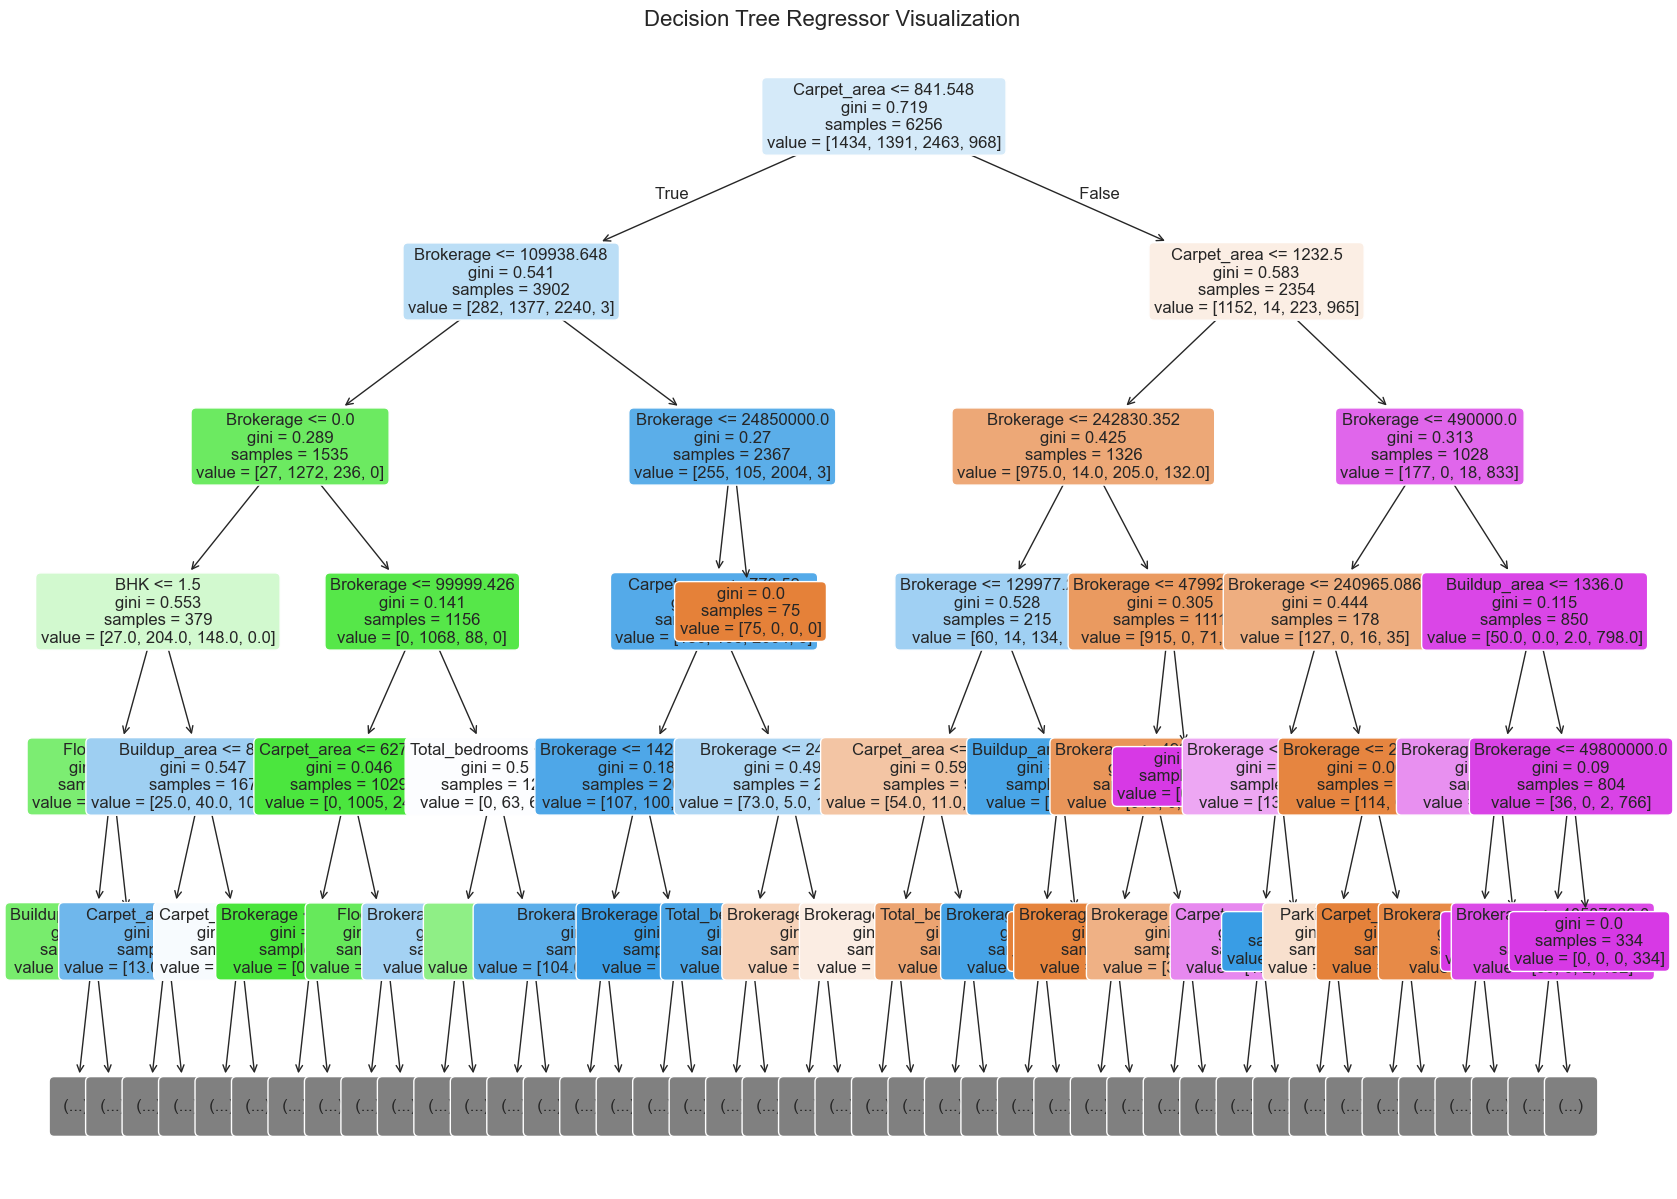

In [88]:
######################################################################################################
#################################### Building Decision Tree Model ####################################
######################################################################################################
# ====================================== Task 1: Model Training ======================================
from sklearn.tree import DecisionTreeClassifier


X_train = train.drop(['Price', 'P_Category'], axis=1)  # Feature variables
X_test = test.drop(['Price', 'P_Category'], axis=1)  # Feature variables

y_train = encoder.fit_transform(train['P_Category'])  # Encode target variable
y_test = encoder.fit_transform(test['P_Category'])  # Encode target variable

# Initialize and train the Decision Tree Regressor
dt_reg = DecisionTreeClassifier()
dt_reg.fit(X_train, y_train)

# Visualize the decision tree with improved settings
plt.figure(figsize=(20, 15))  # Increase the figsize for better readability
plot_tree(dt_reg, feature_names=X.columns, filled=True, rounded=True, fontsize=12, max_depth=5, impurity=True)  # Plot the tree
plt.title("Decision Tree Regressor Visualization", fontsize=16)
plt.show()

Feature Importances: [0.00765671 0.03581676 0.38122965 0.01143698 0.00745244 0.50214909
 0.03469806 0.01377757 0.00578273]


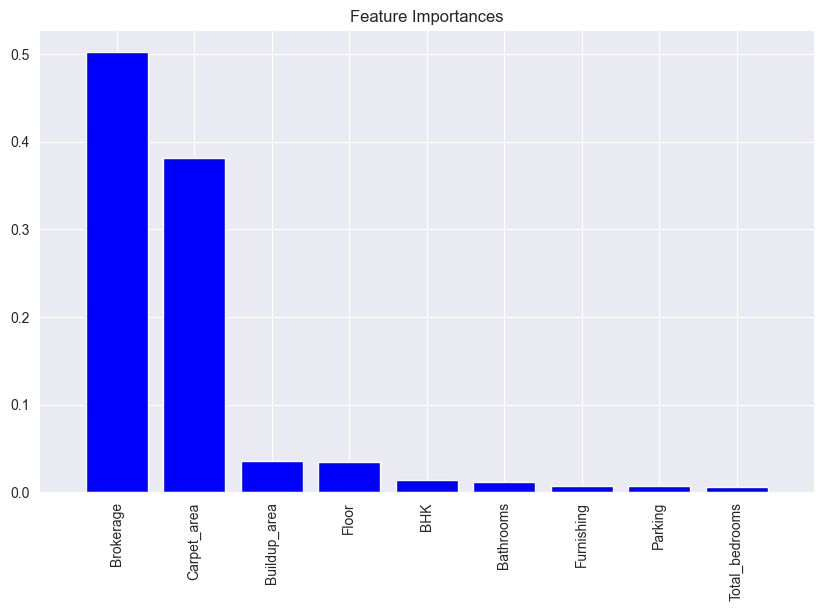

Best parameters found by Grid Search: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Default Model MSE: 0.3657289002557545
Tuned Model MSE: 0.30051150895140666


In [95]:
# ======================= Task 2: Feature Importance and Hyperparameter Tuning =======================
# Extract and plot feature importances
importances = dt_reg.feature_importances_
print("Feature Importances:", importances)
indices = np.argsort(importances)[::-1]  # Sort feature importances

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

imp_cols = X.columns[indices]  # Get the names of the most important features
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=dt_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)  # Fit the GridSearchCV


# Best parameters and model
print("Best parameters found by Grid Search:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Compare performance of default and tuned model
from sklearn.metrics import mean_squared_error

# Default model predictions and MSE
y_pred_default = dt_reg.predict(X_test)
mse_default = mean_squared_error(y_test, y_pred_default)

# Tuned model predictions and MSE
y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)

print(f"Default Model MSE: {mse_default}")
print(f"Tuned Model MSE: {mse_tuned}")

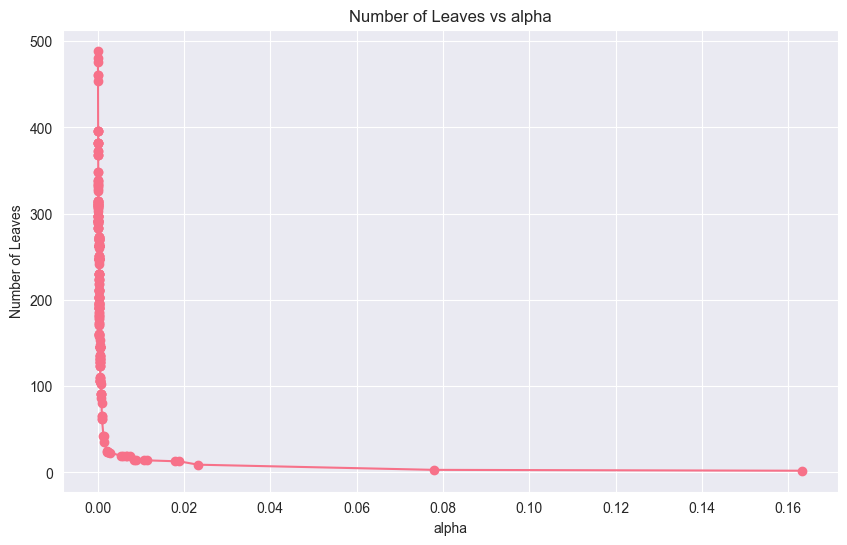

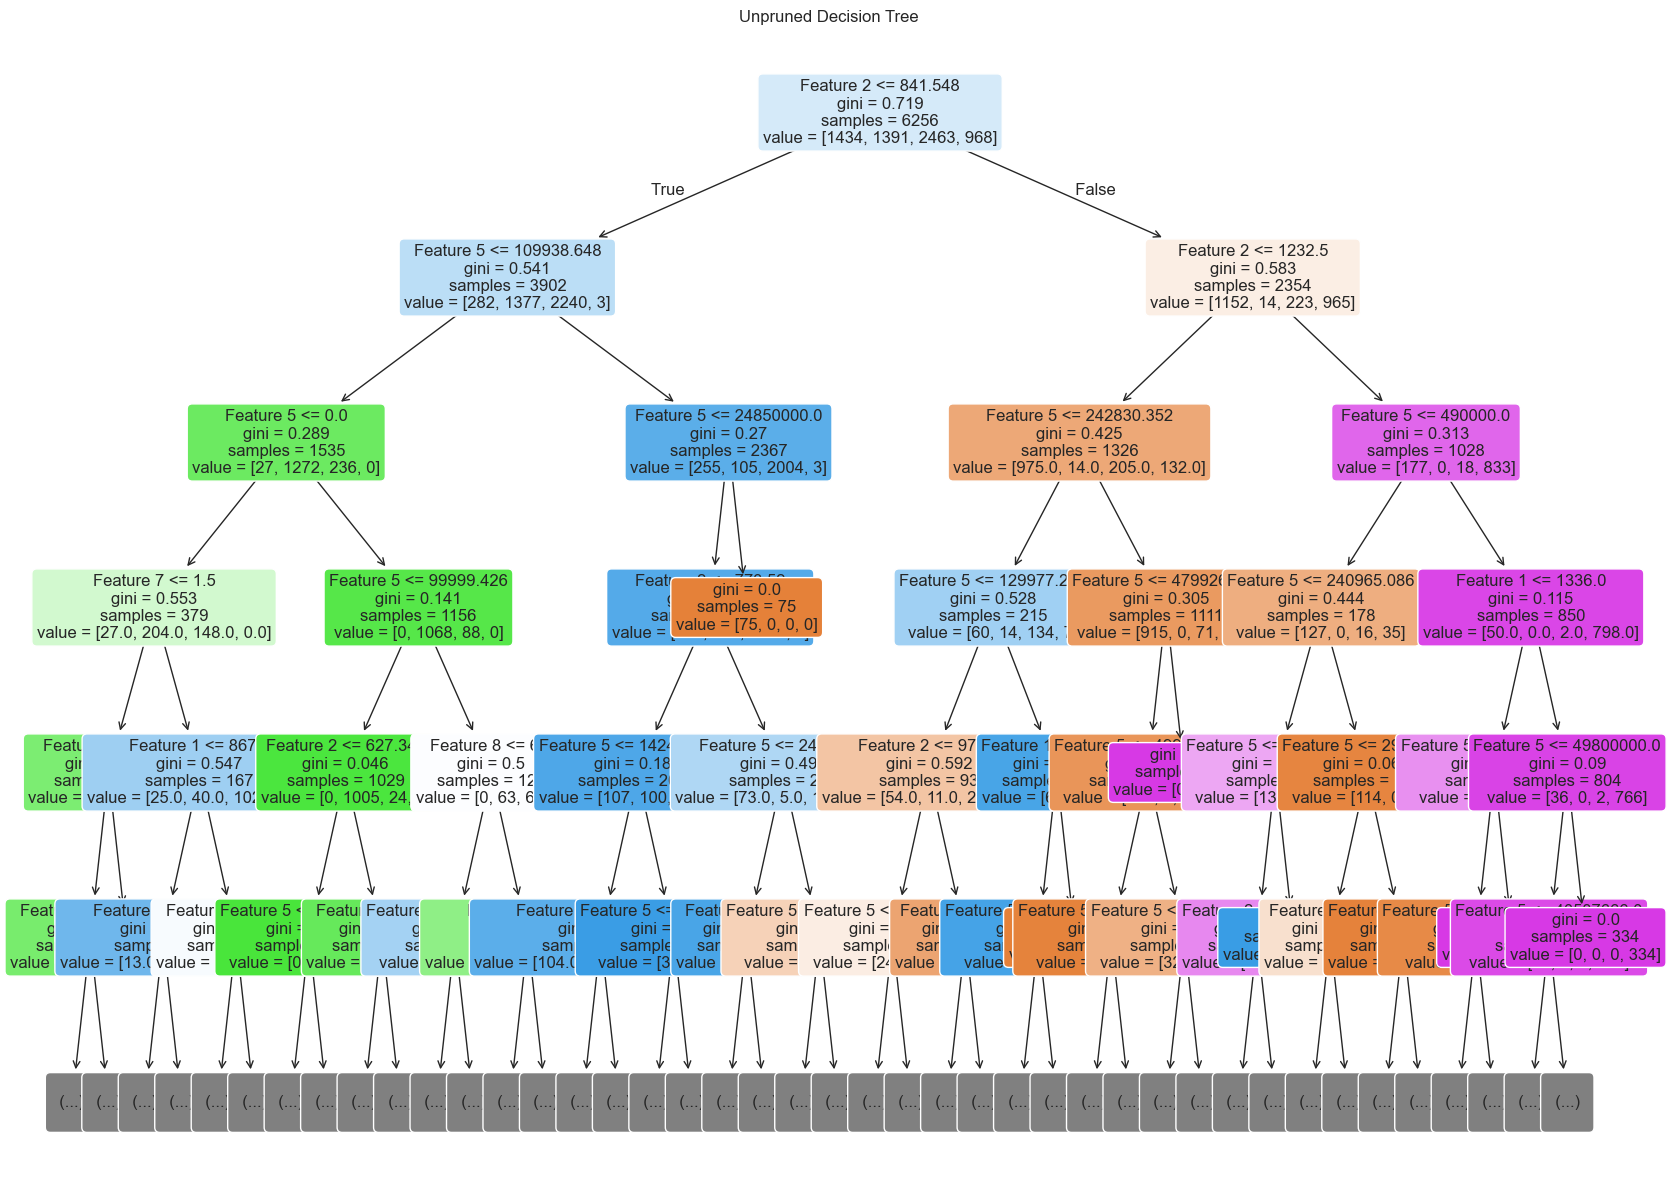

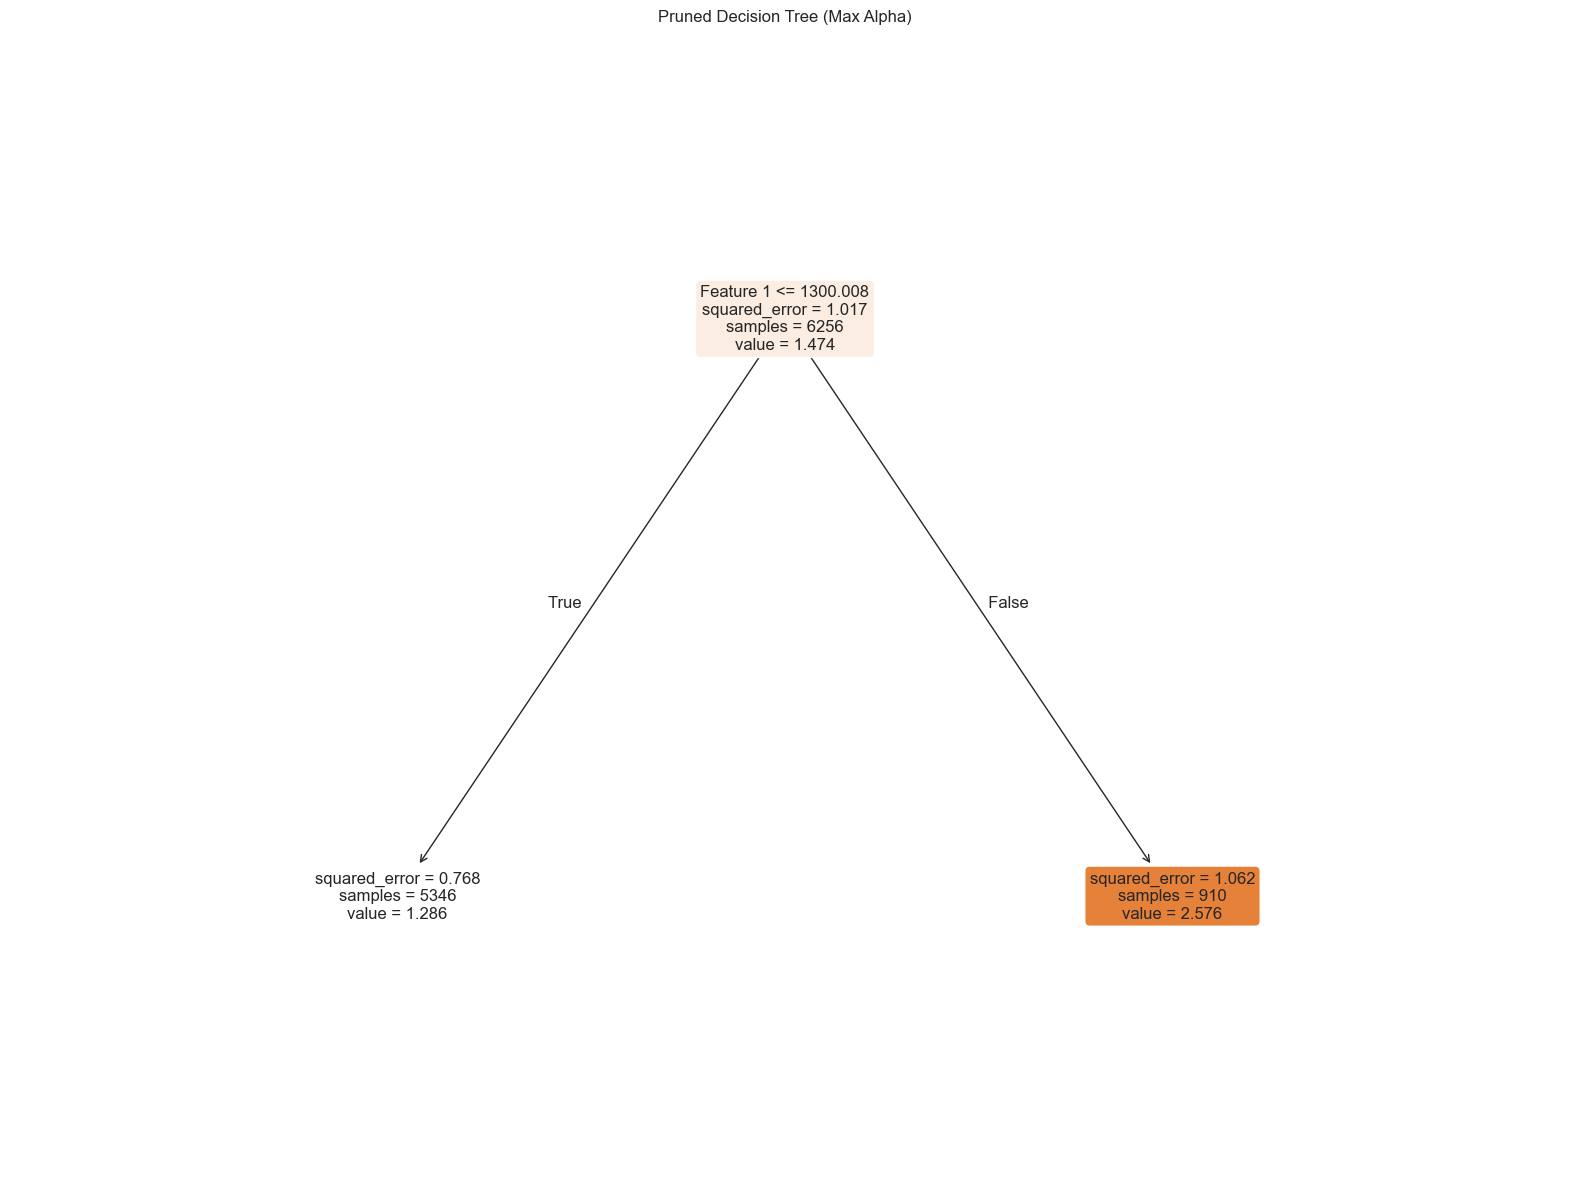

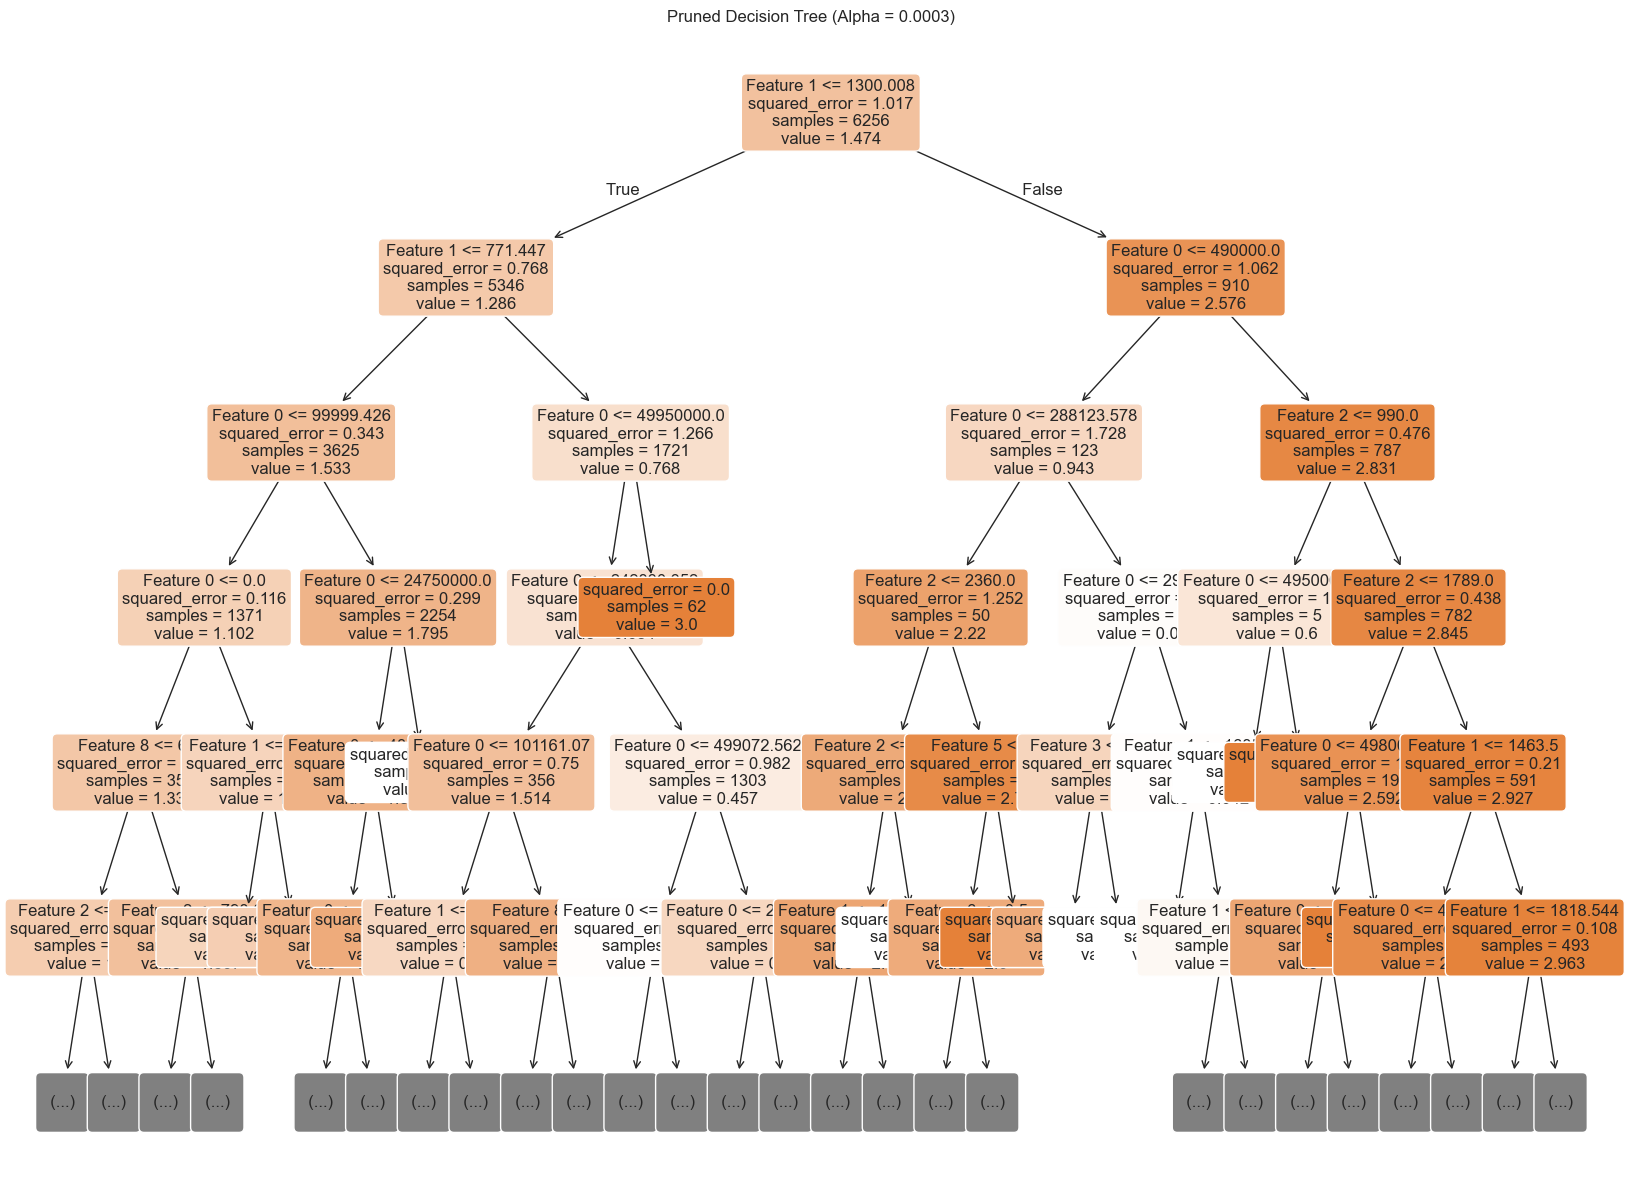

In [96]:
# =================================== Task 3: Pruning Decison Tree ===================================
# Pruning with cost complexity
path = dt_reg.cost_complexity_pruning_path(X_train, y_train)  # Get pruning path
ccp_alphas = path.ccp_alphas  # Alpha values for pruning
dt_pruned = []

for ccp_alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train[imp_cols], y_train)
    dt_pruned.append(model)


node_counts = [model.get_n_leaves() for model in dt_pruned]
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, node_counts, marker='o')
plt.title("Number of Leaves vs alpha")
plt.xlabel("alpha")
plt.ylabel("Number of Leaves")
plt.show()

# Visualize the unpruned tree
plt.figure(figsize=(20, 15))
plot_tree(dt_reg, feature_names=[f'Feature {i}' for i in range(X.shape[1])], filled=True, rounded=True, fontsize=12, max_depth=5, impurity=True)
plt.title("Unpruned Decision Tree")
plt.show()

# Visualize a specific pruned tree (last model in the pruning path)
plt.figure(figsize=(20, 15))
plot_tree(dt_pruned[-1], feature_names=[f'Feature {i}' for i in range(X.shape[1])], filled=True, rounded=True, fontsize=12, max_depth=5, impurity=True)
plt.title("Pruned Decision Tree (Max Alpha)")
plt.show()

# Optionally, visualize the tree with a middle alpha value
middle_alpha_index = len(ccp_alphas) // 2
plt.figure(figsize=(20, 15))
plot_tree(dt_pruned[middle_alpha_index], feature_names=[f'Feature {i}' for i in range(X.shape[1])], filled=True, rounded=True, fontsize=12, max_depth=5, impurity=True)
plt.title(f"Pruned Decision Tree (Alpha = {ccp_alphas[middle_alpha_index]:.4f})")
plt.show()

In [ ]:
# =================================== Task 4: Handling Overfitting ===================================
# (a) Cross-validation to assess model generalization
cv_scores = cross_val_score(dt_reg, X_test, y_test, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

# Fit the model to the training/validation data for later steps
dt_reg.fit(X_test[imp_cols], y_test)

# (b) Implement learning curves
train_sizes, train_scores, validation_scores = learning_curve(dt_reg, X_test, y_test, n_jobs=-1,
                                                              train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, validation_scores_mean, label='Validation score', color='orange')
plt.fill_between(train_sizes, 
                 train_scores_mean - np.std(train_scores, axis=1), 
                 train_scores_mean + np.std(train_scores, axis=1), color='blue', alpha=0.1)
plt.fill_between(train_sizes, 
                 validation_scores_mean - np.std(validation_scores, axis=1), 
                 validation_scores_mean + np.std(validation_scores, axis=1), color='orange', alpha=0.1)
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Visualize the final fitted model
plt.figure(figsize=(20, 10))
plot_tree(dt_reg, filled=True, feature_names=[f'Feature {i}' for i in range(data_features.shape[1])])
plt.title("Fitted Decision Tree")
plt.show()

# (c) Discussion on the role of cross-validation
print("""
Cross-validation is instrumental in controlling overfitting in decision trees. It helps in:
1. **Assessing Generalization**: By training the model on different subsets and validating it on others, we can understand how well the model generalizes to unseen data.
2. **Model Selection**: It aids in selecting hyperparameters that lead to better performance. For instance, we can compare models with different complexities (depth, minimum samples per leaf) to prevent overfitting.
3. **Reducing Variance**: Decision trees are sensitive to small fluctuations in the training data. Cross-validation mitigates this by ensuring that the model is robust across different training sets.
4. **Reliable Error Estimation**: It provides a more reliable estimate of the model's performance by reducing the impact of data noise on training/testing splits.

In conclusion, using cross-validation not only assists in understanding model performance but also helps to choose the right model parameters in order to strike a balance between bias and variance, ultimately controlling overfitting.
""")

## **4. Model Evaluation and Error Analysis**


In [99]:
######################################################################################################
################################ Model Evaluation and Error Analysis #################################
######################################################################################################
# ===================================== Task 1: Model Evaluation =====================================
# (a) Evaluate the model on test data using regression metrics.
y_train_pred = dt_reg.predict(X_test)
y_test_pred = dt_reg.predict(X_test)

# Calculate metrics for training data
mse_train = mean_squared_error(y_test, y_train_pred)
mae_train = mean_absolute_error(y_test, y_train_pred)
r2_train = r2_score(y_test, y_train_pred)

# Calculate metrics for test data
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Report and interpret model performance
print(f"Training Data Metrics:\nMSE: {mse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.2f}")
print(f"Testing Data Metrics:\nMSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.2f}")

Training Data Metrics:
MSE: 0.37, MAE: 0.19, R²: 0.65
Testing Data Metrics:
MSE: 0.37, MAE: 0.19, R²: 0.65


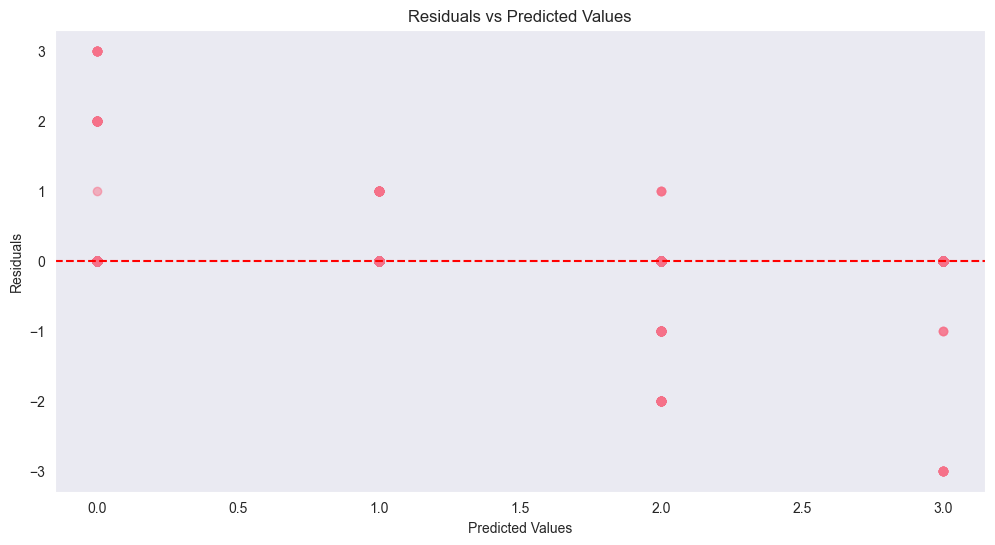

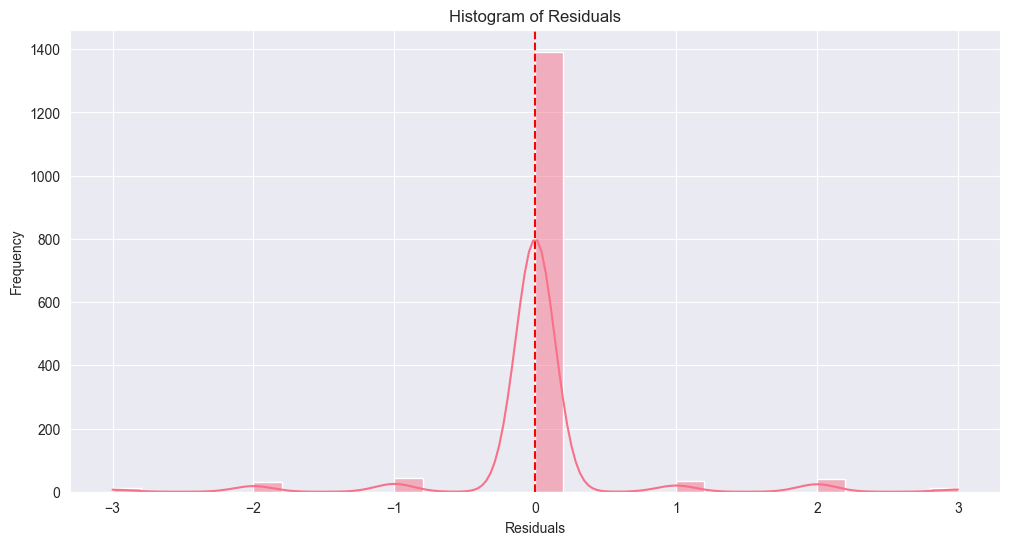

In [100]:
# =============================== Task 2 : Residual and Error Analysis ===============================
# (a) Analyze the residuals
residuals = y_test - y_test_pred

# (b) Visualize the residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [101]:
# ============================ Task 3 : Feature Importance based analysis ============================
# (a) Analyze top 3 important features
# You can extract feature importance if using tree-based models
feature_importance = dt_pruned[middle_alpha_index].feature_importances_
top_indices = np.argsort(feature_importance)[-3:]

# Report the top features and analyze their impact
print("Top 3 important features and their importance scores:")
for i in top_indices:
    print(f"Feature-{i}: Importance Score = {feature_importance[i]:.4f}")

# Calculate RMSE
rmse_test = np.sqrt(mse_test)
print(f"RMSE on test data for the best model: {rmse_test:.2f}")

Top 3 important features and their importance scores:
Feature-2: Importance Score = 0.0388
Feature-1: Importance Score = 0.3558
Feature-0: Importance Score = 0.5483
RMSE on test data for the best model: 0.60


## **5. Bonus Challenge**


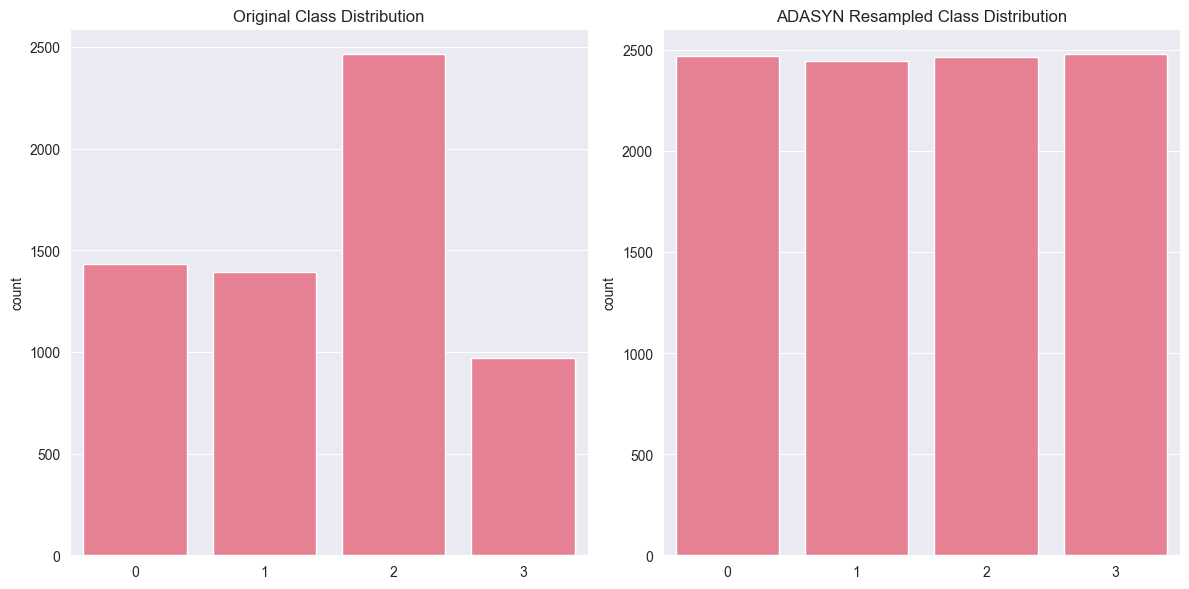


ADASYN generates synthetic samples based on the density distribution of minority class points.
When comparing SMOTE and ADASYN, ADASYN can perform better in scenarios where the data distribution isn't uniform.
SMOTE tends to generate samples around the existing minority class instances, whereas ADASYN adapts to the structure of the data to create new instances.



In [102]:
######################################################################################################
########################################## Bonus Challenge ###########################################
######################################################################################################
# ================================ Task 1:Advanced Imbalance Handling ================================
# (a) Advanced data balancing techniques (Using ADASYN) 
# Assume here you have an imbalanced dataset (Use your own, this is synthetic)
from imblearn.over_sampling import ADASYN, SMOTE
# Apply SMOTE
smote = SMOTE(random_state=0)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# Apply ADASYN
adasyn = ADASYN(random_state=0)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# Compare the class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Original Class Distribution")

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled_adasyn)
plt.title("ADASYN Resampled Class Distribution")

plt.tight_layout()
plt.show()

# (b) Discussing effectiveness
print("""
ADASYN generates synthetic samples based on the density distribution of minority class points.
When comparing SMOTE and ADASYN, ADASYN can perform better in scenarios where the data distribution isn't uniform.
SMOTE tends to generate samples around the existing minority class instances, whereas ADASYN adapts to the structure of the data to create new instances.
""")

In [ ]:
# ============================= Task 2:Ensemble Learning: Random Forest ==============================
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_rf_train_pred = rf_model.predict(X_train)
y_rf_test_pred = rf_model.predict(X_test)

# Calculate metrics for Random Forest model
mse_rf_train = mean_squared_error(y_train, y_rf_train_pred)
mse_rf_test = mean_squared_error(y_test, y_rf_test_pred)

print(f"Random Forest Training MSE: {mse_rf_train:.2f}")
print(f"Random Forest Testing MSE: {mse_rf_test:.2f}")

# Discuss trade-offs
print("""
Random Forest reduces overfitting by averaging the results of multiple decision trees, effectively stabilizing predictions.
While single decision trees can fit the training data very well and often capture too much noise (overfitting), Random Forest classifiers blend many trees to produce a more generalized model. 
However, this makes Random Forest models less interpretable than single decision trees.
""")

NameError: name 'RandomForestRegressor' is not defined